<a href="https://colab.research.google.com/github/MohammadAghaei1/Generative-AI/blob/main/GANs_%26_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import numpy as np
import tensorflow as tf
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input


# **DCGAN**

### **Loading dataset**

In [15]:
# LOAD AND PREPROCESS DATA
print("Loading MNIST data...")
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape from (60000, 28, 28) → (60000, 28, 28, 1)
# Add channel dimension for Conv2D (1 = grayscale)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

Loading MNIST data...


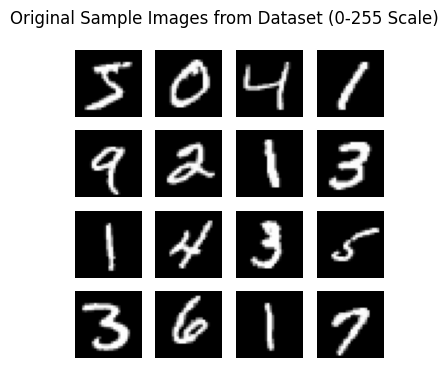

In [16]:
# Load a small sample of original MNIST images to avoid re-normalizing the main dataset
(original_display_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Take the first 16 images for display and reshape them
original_display_images = original_display_images[:16].reshape(-1, 28, 28, 1)

plt.figure(figsize=(4, 4))
for i in range(original_display_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    # Display images directly in their original [0, 255] scale
    plt.imshow(original_display_images[i, :, :, 0], cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
plt.suptitle('Original Sample Images from Dataset (0-255 Scale)')
plt.show()

In [17]:
# Normalize pixel values from [0, 255] → [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Check the shape of the data
print(train_images.shape)

# Dataset parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 128

#  - shuffle it
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE)

(60000, 28, 28, 1)


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


## **Making Generator**

In [19]:
def make_generator_model(noise_dim):
    model = tf.keras.Sequential()

    # Input: Random Noise
    # # Start with a dense layer that outputs a 7x7x128 tensor
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 128)))

    # Upsample from 7x7 to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    # Upsample from 14x14 to 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))  #
    model.add(layers.LeakyReLU())

    # Refine 28x28 (Stride = 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    model.summary()

    return model

In [20]:
NOISE_DIM = 100
generator = make_generator_model(NOISE_DIM)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 128)    │       409,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,269,056 (4.84 MB)

 Trainable params: 1,256,128 (4.79 MB)

 Non-trainable params: 12,928 (50.50 KB)

## **Making Discriminator**

In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # --- Block 1: 32 Filters (Input) ---
    # Matches Code A: Conv2D(32) -> LeakyReLU -> Dropout
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Block 2: 64 Filters ---
    # Matches Code A: Conv2D(64) -> BN -> LeakyReLU -> Dropout
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    # Note: I used padding='same' instead of manual ZeroPadding2D to prevent shape errors
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Block 3: 128 Filters ---
    # Matches Code A: Conv2D(128) -> BN -> LeakyReLU -> Dropout
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Block 4: 256 Filters ---
    # Matches Code A: Conv2D(256) -> BN -> LeakyReLU -> Dropout
    # Note: Strides=1 here (just like Code A) to refine features without shrinking size
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Output ---
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

    return model

In [22]:
discriminator = make_discriminator_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,729 (1.50 MB)

 Trainable params: 392,833 (1.50 MB)

 Non-trainable params: 896 (3.50 KB)

## **Loss functions and optimizers**

In [23]:
# Binary cross-entropy loss for real/fake classification
# from_logits=False because discriminator uses sigmoid
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    """
    real_output: D(real images)  -> should be close to 1
    fake_output: D(fake images)  -> should be close to 0
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)   # label 1 for real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # label 0 for fake
    return real_loss + fake_loss

def generator_loss(fake_output):
    """
    fake_output: D(fake images)
    Generator wants D(fake) ≈ 1 (fool the discriminator)
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # want label 1 for fake


In [24]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

## **Making DCGAN**

In [25]:
@tf.function
def train_step(images):
    """
    Performs one training step on a batch of real images:
      - sample noise
      - generate fake images
      - compute discriminator and generator losses
      - update both networks
      - compute discriminator accuracy on real and fake
    """
    # Sample random noise for the generator: (batch_size, NOISE_DIM)
    # Here batch_size is fixed to 128, matching BATCH_SIZE
    noise = tf.random.normal([128, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images from noise
        generated_images = generator(noise, training=True)

        # Discriminator output for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Compute losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients (update weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # ----- Discriminator accuracies -----
    # Real images: correct if prediction > 0.5 (classified as real)
    real_pred = tf.cast(real_output > 0.5, tf.float32)
    real_acc = tf.reduce_mean(real_pred)  # fraction of real images correctly classified

    # Fake images: correct if prediction <= 0.5 (classified as fake)
    fake_pred_real = tf.cast(fake_output > 0.5, tf.float32)  # 1 if predicted real (wrong)
    fake_acc = tf.reduce_mean(1.0 - fake_pred_real)          # 1 - wrong = correct

    return gen_loss, disc_loss, real_acc, fake_acc


**Function for saving and plotting images**

In [26]:
def generate_and_save_images(model, epoch, test_input):
    """
    Generate images from a fixed noise vector (test_input)
    and plot them in a 4x4 grid.
    """
    # Disable training behavior (e.g., batchnorm updates)
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)

        # Convert from [-1, 1] back to [0, 1] for display
        img_to_plot = (predictions[i, :, :, 0] + 1) / 2.0

        plt.imshow(img_to_plot, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()

## **Training**

In [33]:
import matplotlib.pyplot as plt

# Initialize lists to store metrics for each epoch
gen_loss_history = []
disc_loss_history = []
real_acc_history = []
fake_acc_history = []

# Modify the train function to save the metrics
def train(dataset, epochs):
    print("Starting training with Tanh [-1, 1]...")

    # Batch the dataset here (we kept it unbatched before)
    BATCH_SIZE = 128
    dataset = dataset.batch(BATCH_SIZE)

    for epoch in range(epochs):
        g_loss_metric = 0.0
        d_loss_metric = 0.0
        real_acc_metric = 0.0
        fake_acc_metric = 0.0
        steps = 0

        # Iterate over all batches in the dataset
        for image_batch in dataset:
            g_loss, d_loss, real_acc, fake_acc = train_step(image_batch)
            g_loss_metric += g_loss
            d_loss_metric += d_loss
            real_acc_metric += real_acc
            fake_acc_metric += fake_acc
            steps += 1

        # Average over all batches (epoch metrics)
        avg_g_loss = g_loss_metric / steps
        avg_d_loss = d_loss_metric / steps
        avg_real_acc = real_acc_metric / steps
        avg_fake_acc = fake_acc_metric / steps

        # Store the metrics for plotting
        gen_loss_history.append(avg_g_loss)
        disc_loss_history.append(avg_d_loss)
        real_acc_history.append(avg_real_acc)
        fake_acc_history.append(avg_fake_acc)

        # Print losses + discriminator accuracies (in %)
        print(
            f'Epoch {epoch + 1}, '
            f'Gen Loss: {avg_g_loss:.4f}, '
            f'Disc Loss: {avg_d_loss:.4f}, '
            f'D(real)%: {avg_real_acc * 100:.1f}, '
            f'D(fake)%: {avg_fake_acc * 100:.1f}'
        )

        # Visualize 16 generated images from a fixed noise vector
        generate_and_save_images(generator, epoch + 1, seed)

**Running DCGAN**

Starting training with Tanh [-1, 1]...
Epoch 1, Gen Loss: 1.2180, Disc Loss: 1.0304, D(real)%: 74.9, D(fake)%: 75.0


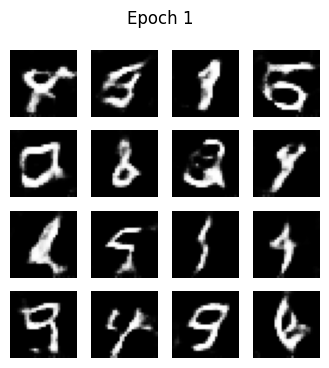

Epoch 2, Gen Loss: 1.2554, Disc Loss: 0.9953, D(real)%: 76.4, D(fake)%: 76.4


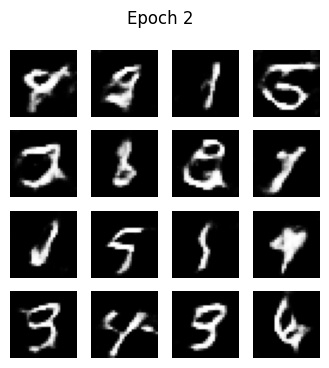

In [34]:
# Fixed noise vector used for monitoring generator progress
seed = tf.random.normal([16, NOISE_DIM])
train(train_dataset, epochs=2)

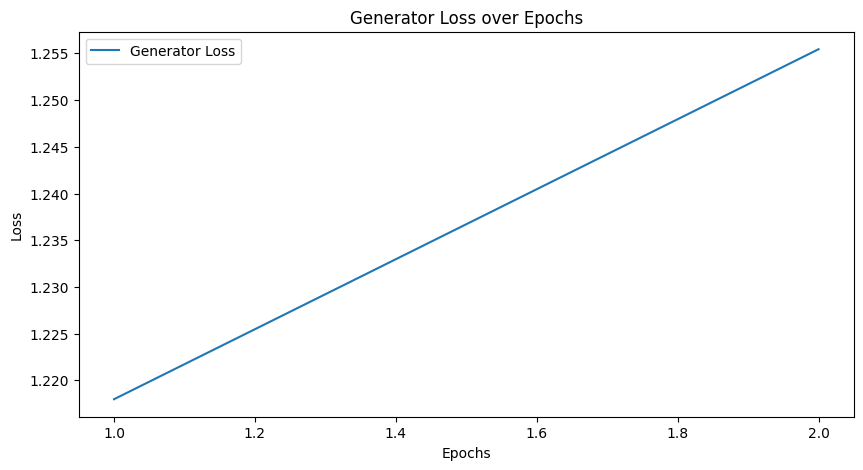

In [36]:
# Plot Generator Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(gen_loss_history) + 1), gen_loss_history, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Loss over Epochs')
plt.legend()
plt.show()

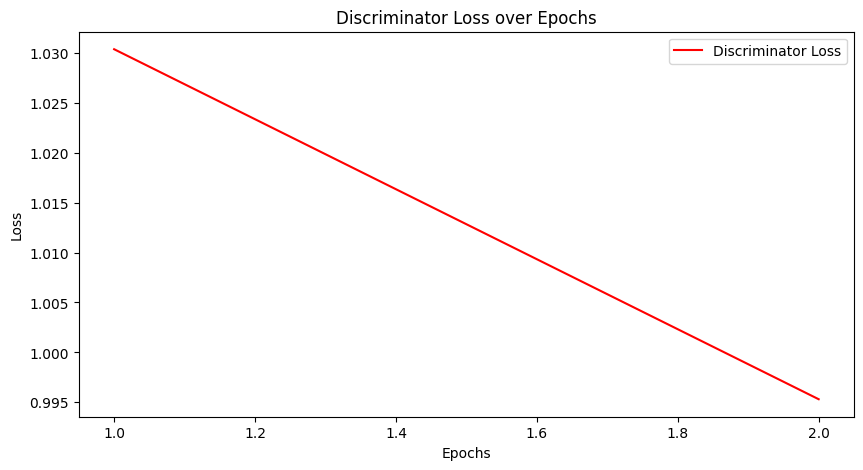

In [37]:
# Plot Discriminator Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(disc_loss_history) + 1), disc_loss_history, label='Discriminator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator Loss over Epochs')
plt.legend()
plt.show()

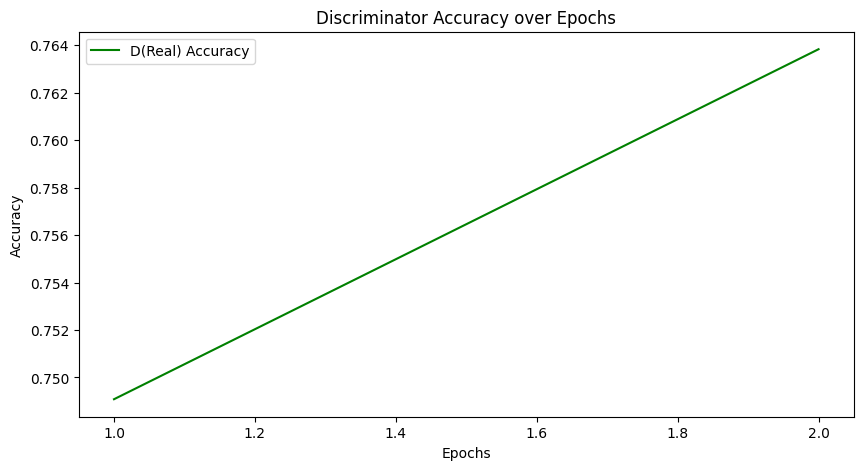

In [39]:
# Plot Discriminator Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(real_acc_history) + 1), real_acc_history, label='D(Real) Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy over Epochs')
plt.legend()
plt.show()


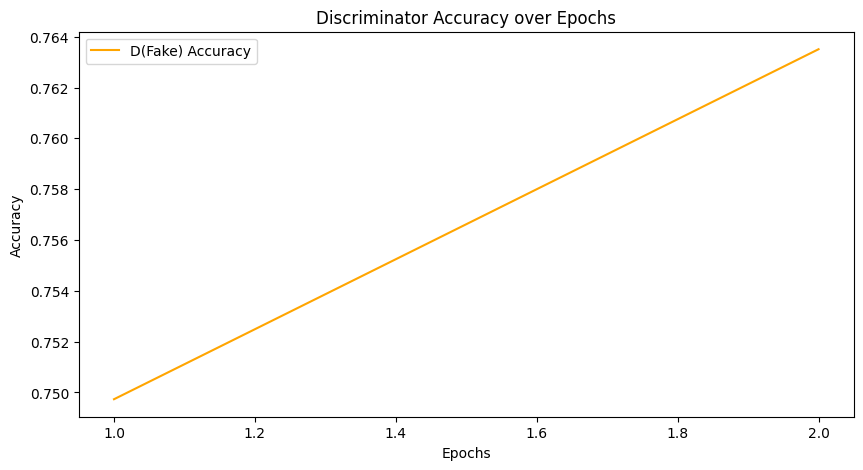

In [40]:
# Plot Discriminator Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(fake_acc_history) + 1), fake_acc_history, label='D(Fake) Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy over Epochs')
plt.legend()
plt.show()

## **FID**

In [ ]:
# We use this pretrained model to extract features for FID calculation
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# --- 2. Helper Functions (Robust & Fixed) ---
def scale_and_resize_images(images):
    """
    Resizes images to 299x299 and converts them to RGB.
    Input images should be in the range [0, 255].
    """
    images_list = []
    for img in images:
        # Convert numpy array to Tensor to avoid 'get_shape' errors
        img = tf.convert_to_tensor(img)

        # --- FIX: If image is 2D (H, W), add the channel dimension (H, W, 1) ---
        if len(img.shape) == 2:
            img = tf.expand_dims(img, axis=-1)
        # -----------------------------------------------------------------------

        # If image is grayscale (1 channel), convert to RGB (3 channels)
        if img.shape[-1] == 1:
            img = tf.image.grayscale_to_rgb(img)

        # Resize to 299x299 for InceptionV3
        img = tf.image.resize(img, [299, 299])
        images_list.append(img)

    # 'preprocess_input' handles the internal normalization for Inception
    return preprocess_input(np.array(images_list))

def calculate_fid(model, real_images, generated_images):
    # Resize and preprocess both sets
    real_images_resized = scale_and_resize_images(real_images)
    gen_images_resized = scale_and_resize_images(generated_images)

    # Extract features
    act1 = model.predict(real_images_resized, verbose=0)
    act2 = model.predict(gen_images_resized, verbose=0)

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate squared difference of means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle numerical instability (complex numbers)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Final FID formula
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# --- 3. Prepare Data ---

# A) Real Images (MNIST)
print("Loading real images...")
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# IMPORTANT: We keep data in [0, 255] range. We do NOT divide by 127.5 here.
train_images = train_images.astype('float32')

# Select 5000 random real images for better statistical accuracy
random_indices = np.random.randint(0, train_images.shape[0], 500)
real_batch = train_images[random_indices]

# B) Generated Images
print("Generating fake images...")
# Define NOISE_DIM if not already defined in your notebook
if 'NOISE_DIM' not in globals():
    NOISE_DIM = 100

noise = tf.random.normal([500, NOISE_DIM])
gen_batch = generator(noise, training=False)

# IMPORTANT: Generator output is [-1, 1]. We must convert it back to [0, 255].
gen_batch = (gen_batch * 127.5) + 127.5

# --- 4. Calculate FID ---
print("Calculating FID (This may take a minute due to resizing)...")
fid_score = calculate_fid(inception_model, real_batch, gen_batch)

print("-" * 30)
print(f"Final FID Score: {fid_score:.4f}")
print("-" * 30)

Loading real images...
Generating VAE images...
Calculating FID on 1000 images (this takes a moment)...


KeyboardInterrupt: 

# **CVAE**

## **Loading dataset**

In [3]:
# LOAD AND PREPROCESS DATA
print("Loading MNIST data...")
(x_train,_), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# Add channel dimension
x_train = np.expand_dims(x_train, -1)  # (60000,28,28,1)
#x_test = np.expand_dims(x_test, -1)

print(x_train.shape)

Loading MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28, 1)


## **Encoder**

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

latent_dim = 16

# Reparameterization trick
def sampling(args):
    mean, logvar = args
    eps = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * logvar) * eps

def make_encoder_model(latent_dim):

    # ---- Sequential backbone (exact style you asked) ----
    model = tf.keras.Sequential(name="encoder_backbone")

    # Input: 28x28x1 image
    model.add(layers.Input(shape=(28, 28, 1)))

    # Conv blocks (same params as your code)
    model.add(layers.Conv2D(32, 3, activation="relu",
                            strides=2, padding="same"))
    model.add(layers.Conv2D(64, 3, activation="relu",
                            strides=2, padding="same"))
    model.add(layers.Conv2D(128, 3, activation="relu",
                            strides=1, padding="same"))

    # Flatten + dense (same as your code)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))

    # ---- Functional part for multiple VAE outputs ----
    encoder_inputs = layers.Input(shape=(28, 28, 1), name="encoder_input")
    x = model(encoder_inputs)   # pass input through the Sequential backbone

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    return encoder

# build the encoder
encoder = make_encoder_model(latent_dim)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_backbone    │ (None, 256)       │  1,698,560 │ encoder_input[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      4,112 │ encoder_backbone… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      4,112 │ encoder_backbone… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,706,784 (6.51 MB)

 Trainable params: 1,706,784 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

## **Decoder**

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

latent_dim = 16   # or whatever you use

# ---------------- DECODER WITH Sequential ----------------
def make_decoder_model(latent_dim):
    model = tf.keras.Sequential(name="decoder")

    # Input: latent vector (latent_dim,)
    model.add(layers.Input(shape=(latent_dim,)))

    # Dense + reshape (same as your code)
    model.add(layers.Dense(7 * 7 * 128, activation="relu"))
    model.add(layers.Reshape((7, 7, 128)))

    # Conv2DTranspose blocks (same params as your code)
    model.add(layers.Conv2DTranspose(128, 3, activation="relu",
                                     strides=1, padding="same"))
    model.add(layers.Conv2DTranspose(64, 3, activation="relu",
                                     strides=2, padding="same"))
    model.add(layers.Conv2DTranspose(32, 3, activation="relu",
                                     strides=2, padding="same"))

    # Output layer (same: 1 channel, sigmoid)
    model.add(layers.Conv2DTranspose(1, 3, activation="sigmoid",
                                     padding="same"))

    model.summary()
    return model

decoder = make_decoder_model(latent_dim)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6272)           │       106,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,753 (1.32 MB)

 Trainable params: 346,753 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

## **Vae**

In [36]:
class VAE(Model):
    def __init__(self, encoder, decoder, beta=2, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def compute_losses(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Reconstruction loss
        recon_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(data, reconstruction)
        ) * 28 * 28

        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        # Total β-VAE loss
        total_loss = recon_loss + self.beta * kl_loss
        return total_loss, recon_loss, kl_loss

    # ---- Training step ----
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            total_loss, recon_loss, kl_loss = self.compute_losses(data)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # ---- Validation step ----
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        total_loss, recon_loss, kl_loss = self.compute_losses(data)

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## **Training**

In [37]:
vae = VAE(encoder, decoder, beta=2)
vae.compile(optimizer="adam")
history = vae.fit(x_train, epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - kl_loss: 2.8513 - loss: 66.2844 - recon_loss: 60.5818 - val_kl_loss: 2.8797 - val_loss: 68.3556 - val_recon_loss: 62.5962
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - kl_loss: 2.8659 - loss: 64.9314 - recon_loss: 59.1996 - val_kl_loss: 2.8371 - val_loss: 68.3847 - val_recon_loss: 62.7104
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 2.8609 - loss: 64.8509 - recon_loss: 59.1291 - val_kl_loss: 2.8802 - val_loss: 68.8405 - val_recon_loss: 63.0802
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 2.8647 - loss: 64.8785 - recon_loss: 59.1492 - val_kl_loss: 2.8800 - val_loss: 68.3449 - val_recon_loss: 62.5849
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 2.8561 - loss: 64.7515 - recon_loss: 59.0394 - val_kl_loss: 2.8149 - val_loss: 68.5515 - val_recon_loss: 62.9218


In [38]:
# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_recon_loss = history.history['recon_loss']
val_recon_loss = history.history['val_recon_loss']
train_kl_loss = history.history['kl_loss']
val_kl_loss = history.history['val_kl_loss']


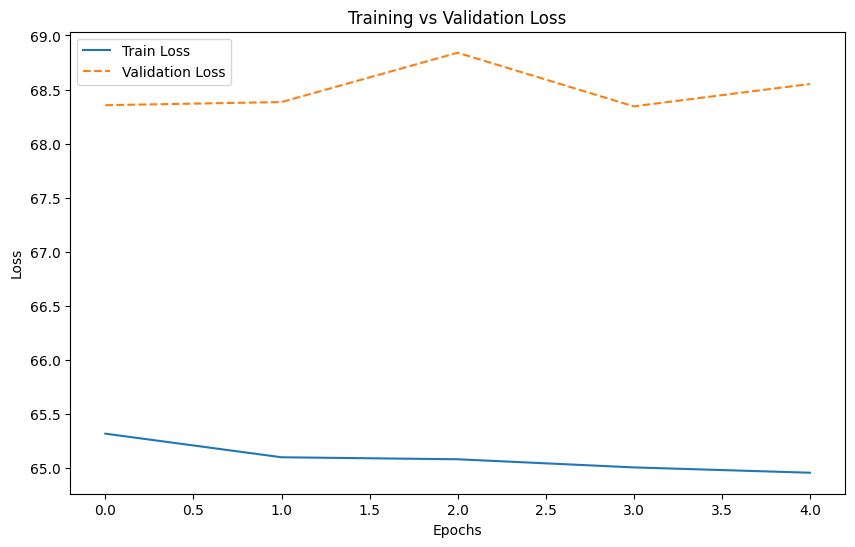

In [39]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss", linestyle="--")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


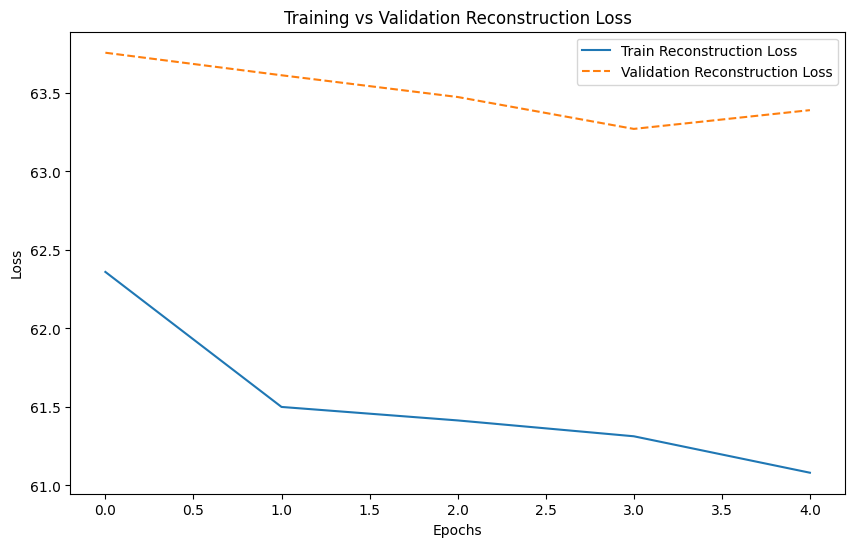

In [20]:
# Plot training and validation reconstruction loss
plt.figure(figsize=(10, 6))
plt.plot(train_recon_loss, label="Train Reconstruction Loss")
plt.plot(val_recon_loss, label="Validation Reconstruction Loss", linestyle="--")
plt.title("Training vs Validation Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


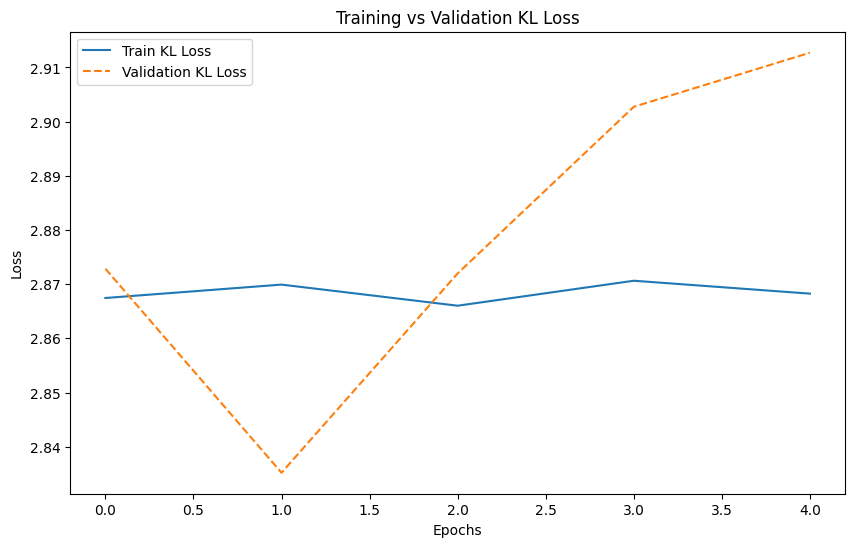

In [21]:
# Plot training and validation KL loss
plt.figure(figsize=(10, 6))
plt.plot(train_kl_loss, label="Train KL Loss")
plt.plot(val_kl_loss, label="Validation KL Loss", linestyle="--")
plt.title("Training vs Validation KL Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


## **Visualization**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


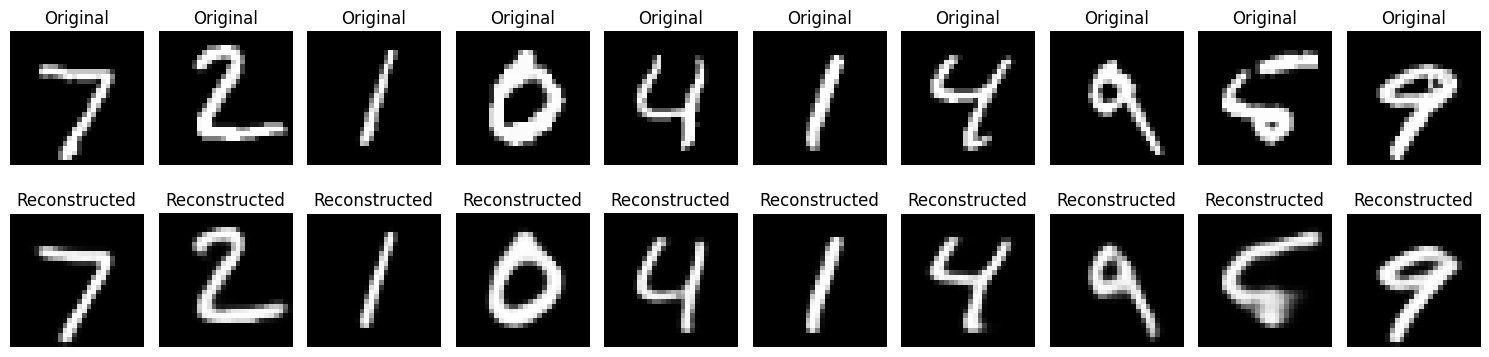

In [ ]:
import matplotlib.pyplot as plt

# Select 10 test images
x_sample = x_test[:10]
reconstructed = vae.predict(x_sample)

plt.figure(figsize=(15, 4))

for i in range(10):
    # Original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_sample[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstruction
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed[i].squeeze(), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


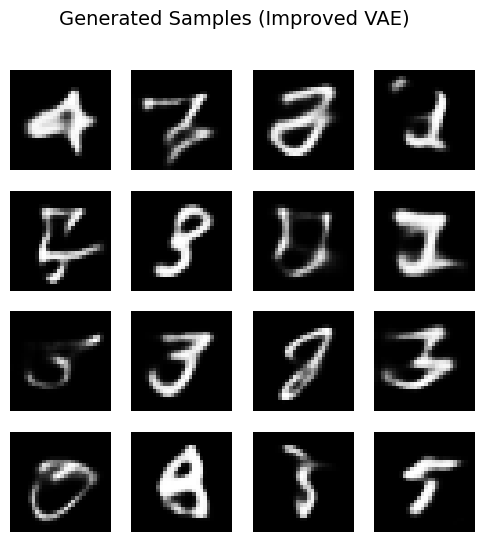

In [ ]:
import matplotlib.pyplot as plt

# Sample random z vectors
z_random = tf.random.normal(shape=(16, latent_dim))

# Generate images from decoder
generated = decoder(z_random)

plt.figure(figsize=(6, 6))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated[i].numpy().squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("Generated Samples (Improved VAE)", fontsize=14)
plt.show()


## **FID**

In [ ]:
# We use this pretrained model to extract features for FID calculation
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# --- 2. Helper Functions ---
def scale_and_resize_images(images):
    """
    Resizes images to 299x299 and converts them to RGB.
    Input images should be in the range [0, 255].
    """
    images_list = []
    for img in images:
        # Convert numpy array to Tensor
        img = tf.convert_to_tensor(img)

        # If image is 2D (28, 28), add channel dim -> (28, 28, 1)
        if len(img.shape) == 2:
            img = tf.expand_dims(img, axis=-1)

        # If image is grayscale (1 channel), convert to RGB (3 channels)
        if img.shape[-1] == 1:
            img = tf.image.grayscale_to_rgb(img)

        # Resize to 299x299 for InceptionV3
        img = tf.image.resize(img, [299, 299])
        images_list.append(img)

    # 'preprocess_input' expects inputs [0, 255] for InceptionV3 default mode
    return preprocess_input(np.array(images_list))

def calculate_fid(model, real_images, generated_images):
    # Resize and preprocess both sets
    real_images_resized = scale_and_resize_images(real_images)
    gen_images_resized = scale_and_resize_images(generated_images)

    # Extract features
    act1 = model.predict(real_images_resized, verbose=0)
    act2 = model.predict(gen_images_resized, verbose=0)

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate squared difference of means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle numerical instability (complex numbers)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Final FID formula
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# --- 3. Prepare Data for VAE ---

# A) Real Images (MNIST)
# We use the test set here to see how well the VAE generalizes
print("Loading real images...")
(_, _), (x_test_fid, _) = tf.keras.datasets.mnist.load_data()

# Ensure float32 and range [0, 255]
x_test_fid = x_test_fid.astype('float32')

# Pick a random batch of real images (e.g., 1000 for better statistical significance)
n_samples = 500
random_indices = np.random.randint(0, x_test_fid.shape[0], n_samples)
real_batch = x_test_fid[random_indices]

# B) Generated Images (VAE)
print("Generating VAE images...")

# 1. Sample from the latent space (Standard Normal Distribution)
# Your latent_dim was defined as 16 in your code
latent_dim = 16
random_latents = tf.random.normal(shape=(n_samples, latent_dim))

# 2. Decode the latents
# Note: Your decoder has a 'sigmoid' activation, so output is [0, 1]
gen_batch = decoder.predict(random_latents, verbose=0)

# 3. Scale back to [0, 255] for the FID function
gen_batch = gen_batch * 255.0

# --- 4. Calculate FID ---
print(f"Calculating FID on {n_samples} images (this takes a moment)...")
fid_score = calculate_fid(inception_model, real_batch, gen_batch)

print("-" * 30)
print(f"Final VAE FID Score: {fid_score:.4f}")
print("-" * 30)

Loading real images...
Generating VAE images...
Calculating FID on 1000 images (this takes a moment)...
------------------------------
Final VAE FID Score: 53.4942
------------------------------
